In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_context('notebook')


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'



from evaluation import *
from PreEmo import *
from DestiRec import DestiRec
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')
warnings.filterwarnings("ignore", 'invalid value encountered in true_divide')
warnings.filterwarnings("ignore", 'A class named ')

### This Notebook is for running experiments and evaluation of the implementation of the nsga-iii algorithm and it's variants

First we initialiaze the log file for output logs

In [3]:
init_logging('../logs/evaluation.log', append=True)


Then we run the prepared evaluation file

In [3]:
#evaluation.run()

Get Information about feasible vs Infeasible Individuals produced in Variant 1 and 2

In [12]:
import pickle
with open ('../logs/results/Feasbility.pickle','rb') as f:
    feasibility_info = pickle.load(f)

In [13]:
def get_main_df(feasibility_info):
    tests = ['test1', 'test2']
    main_df = pd.DataFrame()
    for variant in tests:
        test = feasibility_info[variant]
        for inputnum in range(3):
            result = test[inputnum]
            for i, gen in enumerate(result):    
                df = pd.DataFrame(gen['feasibility'])
                df.replace([np.inf, -np.inf], np.nan, inplace=True)
                df = df.dropna(subset=[0, 1], how="all")
                df['Run'] = i
                df['Input'] = int(gen['Input'])
                df['Variant'] = variant
                if(main_df.empty):
                    main_df = df
                else:
                    main_df = pd.concat([main_df, df], ignore_index=True)
    main_df = main_df.rename(columns={1:'Feasibility'})
    return main_df
    

In [14]:
main_df = get_main_df(feasibility_info)

In [15]:
def draw_feasibility_stats(main_df):
    '''sub routine to draw the stats about feasbile vs infeasbile individuals '''
    fig = plt.figure(figsize=(10,10))
    #ax = fig.add_subplot(111)
    
    palette = {
    'Feasible': 'tab:green',
    'Infeasible': 'tab:red',
    }
   
    g = sns.displot(main_df,x='Individual', hue='Feasibility', stat='percent', multiple="stack",  legend=True, palette=palette, row='Variant', aspect=1.5)  
    for ax in g.axes:
        ax[0].set_yscale('log')
    

In [17]:
new_df = pd.DataFrame()
for i, g in main_df.groupby(['Variant', 'Run','Input']):
    g['Individual'] = [x for x in range(len(g))]
    new_df = pd.concat([new_df, g], ignore_index=True)

In [21]:
new_df = new_df.drop(0, axis=1)


In [23]:
new_df = new_df[['Individual', 'Run', 'Variant', 'Input', 'Feasibility']]

In [25]:
new_df['Variant'] = new_df['Variant'].map(lambda x: x[-1])

In [295]:
new_df.to_csv('../logs/results/variant12_feasibility.csv', index=False)

In [30]:
test_df = new_df.groupby(['Individual','Variant'])['Feasibility'].value_counts(normalize=True)
test_df = test_df.mul(100).rename('Percent').reset_index()

In [104]:
test_df['Percent'] = test_df['Percent'].round(decimals=2)

In [106]:
test_df.to_csv('../logs/results/variant12_feasibility.csv', index=False)

Extraction and Transformation of Survey Responses. We want to pivot the columns of the csv file to rows

In [3]:
#get the column data first
survey_col_names = pd.read_csv('../logs/survey_resp.csv', index_col=0, nrows=0)


In [250]:
cols = survey_col_names.columns.to_list()
for i, x in enumerate(cols):
    size = len(x)
    if('.' in x):
        cols[i] = x[:size -2]
    size = len(cols[i])
    while ('.' in cols[i]):
        cols[i] = cols[i][:size -1]
        size = len(cols[i])

In [252]:
questions = {'Q'+str(x): cols[x]  for x in range(8) }

In [253]:
d = {'A':[questions['Q0']], 'B':[questions['Q1']], 'C':[questions['Q2']], 'D':[questions['Q3']],
    'E': [questions['Q4'],'The recommended region matches the input preferences'], 'F':[questions['Q5']], 'G':[questions['Q6']], 'H':[questions['Q7']]
}

In [254]:
inputs = ['1', '2', '3']
variants = ['1', '2', '3','4']
question_metadata = dict()
temp = variants.copy()
counter = 0
for i,col in enumerate(cols):
    if i<4:
        question_metadata['Q_A_'+str(i)] = col
    else:
        var = temp[0]
        inp = inputs[0]
        t = [k for k, v in d.items() if col in v]
        question_metadata['Q_'+var+'_'+inp+'_'+ t[0]] = col
        counter +=1
        if (i<(len(cols) -1) and (cols[i+1] in d['E'])):
            temp.pop(0)
            counter = 0
        if len(temp) == 0:
            temp = variants.copy()
            inputs.pop(0)
        
    

In [296]:
survey_responses= pd.read_csv('../logs/survey_resp.csv', sep=',', header=None, index_col=0, names=question_metadata.keys())

In [297]:
survey_responses = survey_responses.reindex(sorted(survey_responses.columns), axis=1)

In [298]:
survey_responses = survey_responses.iloc[1: , :]

In [299]:
survey_responses = survey_responses.fillna(0)
survey_responses.index.names = ['Timestamp']

In [300]:
survey_responses = survey_responses.reset_index()

In [380]:
question_metadata

{'Q_A_0': 'How often do you travel for vacation?',
 'Q_A_1': 'How good are you at planning vacations?',
 'Q_A_2': 'What are your preferred travel experiences?',
 'Q_A_3': 'Do you tend to trust a person/thing, even though you have little knowledge of it',
 'Q_1_1_E': 'The recommended regions matched the input preferences',
 'Q_1_1_F': 'This recommender system gave me good suggestions for this scenario',
 'Q_1_1_G': 'The regions recommended are diverse',
 'Q_1_1_H': 'The recommended regions fit well together',
 'Q_2_1_E': 'The recommended regions matched the input preferences',
 'Q_2_1_F': 'This recommender system gave me good suggestions for this scenario',
 'Q_2_1_G': 'The regions recommended are diverse',
 'Q_2_1_H': 'The recommended regions fit well together',
 'Q_3_1_E': 'The recommended regions matched the input preferences',
 'Q_3_1_F': 'This recommender system gave me good suggestions for this scenario',
 'Q_3_1_G': 'The regions recommended are diverse',
 'Q_3_1_H': 'The recommen

In [301]:
Labels_numeric_groups = {0: 'Not Applicable', 1: 'Strongly Disagree', 2:'Disagree', 3:'Neutral', 4:'Agree', 5:'Strongly Agree'}
Labels_demographic_A0 = {0:'Never', 1:'Very Infrequently', 2:'Infrequently', 3:'Moderately', 4:'Regularly', 5:'Very Regularly'}
Labels_demographic_A1 = {0:'No Experience', 1:'Basic', 2:'Average', 3:'Average', 4:'Advanced', 5:'Advanced'}
Labels_demographic_A3 = {0:'No Trust', 1:'No Trust', 2:'Average Trust', 3:'Average Trust', 4:'High Trust', 5:'High Trust'}


In [302]:
inputs = {'1': 'Beach; Watersports; Entertainment; Culinary;','2': 'Nature & Wildlife; Hiking; Culture;', '3':'Cities & Architecture; Culture; Culinary; Shopping'}
variants = {'1': 'Variant 1', '2': 'Variant 2', '3': 'Variant 5', '4': 'Variant 6'}

In [303]:
id_vars = list(question_metadata.keys())[:4]
id_vars.append('Timestamp')
survey_responses = survey_responses.melt(id_vars=id_vars, 
        var_name="Question ID", 
        value_name="Value")

In [304]:
survey_responses['Labels'] = survey_responses['Value'].map(lambda x: Labels_numeric_groups[int(x)])

In [305]:
survey_responses['Q_A_0'] = survey_responses['Q_A_0'].map(lambda x: Labels_demographic_A1 [int(x)])

In [306]:
survey_responses['Q_A_1'] = survey_responses['Q_A_1'].map(lambda x: Labels_demographic_A1 [int(x)])

In [307]:
survey_responses['Q_A_2'] = survey_responses['Q_A_2'].map(lambda x: x.replace(',', ';'))

In [308]:
survey_responses['Q_A_3'] = survey_responses['Q_A_3'].map(lambda x: Labels_demographic_A3 [int(x)])

In [309]:
survey_responses['InputCategory'] = survey_responses['Question ID'].map(lambda x: inputs[x[4]])
survey_responses['Variant'] = survey_responses['Question ID'].map(lambda x: variants[x[2]])

In [310]:
survey_responses['Wording'] = survey_responses['Question ID'].map(lambda x: question_metadata[x])

In [311]:
survey_responses = survey_responses.rename(columns={'Q_A_0': 'Travel Experience', 'Q_A_1': 'Travel Planning', 'Q_A_2':'Travel Preferences', 'Q_A_3':'Trust Level'})

In [312]:
survey_responses = survey_responses.set_index('Timestamp')

In [319]:
survey_responses.InputCategory.unique()

array(['Beach; Watersports; Entertainment; Culinary;',
       'Nature & Wildlife; Hiking; Culture;',
       'Cities & Architecture; Culture; Culinary; Shopping'], dtype=object)

Transformed data ready for analysis

In [313]:
survey_responses

,Travel Experience,Travel Planning,Travel Preferences,Trust Level,Question ID,Value,Labels,InputCategory,Variant,Wording
Timestamp,,,,,,,,,,
4/8/2022 17:35:43,Advanced,Advanced,Culture; Watersports; Cities & Architecture; N...,No Trust,Q_1_1_E,2,Disagree,Beach; Watersports; Entertainment; Culinary;,Variant 1,The recommended regions matched the input pref...
4/8/2022 17:46:02,Average,Advanced,Culture; Cities & Architecture; Nature & Wildlife,Average Trust,Q_1_1_E,3,Neutral,Beach; Watersports; Entertainment; Culinary;,Variant 1,The recommended regions matched the input pref...
4/8/2022 17:49:39,Average,Average,Nature & Wildlife,High Trust,Q_1_1_E,3,Neutral,Beach; Watersports; Entertainment; Culinary;,Variant 1,The recommended regions matched the input pref...
4/8/2022 18:20:36,Average,Average,Culture; Culinary; Cities & Architecture; Natu...,Average Trust,Q_1_1_E,3,Neutral,Beach; Watersports; Entertainment; Culinary;,Variant 1,The recommended regions matched the input pref...
4/8/2022 18:23:57,Average,Average,Culture; Culinary; Cities & Architecture; Ente...,Average Trust,Q_1_1_E,3,Neutral,Beach; Watersports; Entertainment; Culinary;,Variant 1,The recommended regions matched the input pref...
...,...,...,...,...,...,...,...,...,...,...
4/14/2022 0:12:59,Average,Advanced,Culture; Cities & Architecture; Shopping,Average Trust,Q_4_3_H,2,Disagree,Cities & Architecture; Culture; Culinary; Shop...,Variant 6,The recommended regions fit well together
4/14/2022 13:48:45,Average,Average,Culture; Culinary; Watersports; Cities & Archi...,High Trust,Q_4_3_H,3,Neutral,Cities & Architecture; Culture; Culinary; Shop...,Variant 6,The recommended regions fit well together
4/14/2022 14:49:09,Average,Advanced,Culture; Nature & Wildlife; Beach,No Trust,Q_4_3_H,2,Disagree,Cities & Architecture; Culture; Culinary; Shop...,Variant 6,The recommended regions fit well together


In [314]:
survey_responses.to_csv('../logs/survey_response_clean.csv',sep=',', header=True, index=True)

Extraction and Transformation of Online Evaluation Results of all variants

In [322]:
outputs = dict() #to contain 6 elements;one for each test
tests = ['test1', 'test2', 'test3', 'test4', 'test5', 'test6']
inputs = ['input1', 'input2', 'input3']
for test in tests:
    for input in inputs:
        path = f'logs/results/Test_{test}-{input}.pickle'
        with open (path,'rb') as f:
            loaded = pickle.load(f)
        if test not in outputs.keys():
            outputs[test] = list()
        outputs[test].append(loaded['Process'])



In [325]:
def parse_result_to_df(outputs):
    tests = ['test1', 'test2', 'test3', 'test4', 'test5', 'test6']  
    inputs = ['input1', 'input2', 'input3']
    main_df = pd.DataFrame()
    for variant in tests:
        for i, input in enumerate(inputs):
            result = outputs[variant][i]
            for i, gen in enumerate(result):    
                df = pd.DataFrame(gen['feasibility'])
                df.replace([np.inf, -np.inf], np.nan, inplace=True)
                df = df.dropna(subset=[0, 1], how="all")
                df['Generation'] = i
                df['Input'] = input[-1]
                df['Input'] = df['Input'].astype('category')
                df['Variant'] = variant[-1]
                df['Variant'] = df['Variant'].astype('category')
                if(main_df.empty):
                    main_df = df
                else:
                    main_df = pd.concat([main_df, df], ignore_index=True)
    main_df = main_df.rename(columns={1:'Feasibility', 0:'Total Score'})
    return main_df

In [326]:
result = parse_result_to_df(outputs)

In [334]:
result.to_csv('../logs/best_results.csv', index=False)

In [346]:
evaluation_res = pd.read_csv('../logs/results/evaluation.csv')

In [379]:
evaluation_res.loc[((evaluation_res['Input']==3) & (evaluation_res['Variant']==4))].sort_values(by='Score', ascending=False)

,Nrun,Variant,Input,Score,Nregions,EvaluatedRegions,EvaluatedCombinations,Totaltime,SuggestedRegions,SuggestedDuration,SuggestedBudget
192,0,4,3,10.0,1,5,69,67.91,Greenland,Greenland-1.0,Greenland-975.0
193,0,4,3,10.0,1,5,69,67.91,Greenland,Greenland-1.0,Greenland-975.0
208,4,4,3,10.0,1,5,66,73.02,Greenland,Greenland-1.0,Greenland-975.0
207,4,4,3,10.0,1,5,66,73.02,Greenland,Greenland-1.0,Greenland-975.0
206,3,4,3,10.0,1,5,72,73.58,Greenland,Greenland-1.0,Greenland-975.0
205,3,4,3,10.0,1,5,72,73.58,Greenland,Greenland-1.0,Greenland-975.0
204,3,4,3,10.0,1,5,72,73.58,Greenland,Greenland-1.0,Greenland-975.0
203,3,4,3,10.0,1,5,72,73.58,Greenland,Greenland-1.0,Greenland-975.0
202,2,4,3,10.0,1,5,86,69.92,Greenland,Greenland-1.0,Greenland-975.0
201,2,4,3,10.0,1,5,86,69.92,Greenland,Greenland-1.0,Greenland-975.0


In [362]:
temp_df = evaluation_res.groupby(['Variant'])['Score'].describe().round(2)
temp_df['Avg Time (s)'] = evaluation_res.groupby(['Variant'])['Totaltime'].mean().round(2)

In [364]:
temp_df.drop('count', axis=1).to_csv('../logs/results/online_evals_summary.csv', index=True)

In [363]:
temp_df

,count,mean,std,min,25%,50%,75%,max,Avg Time (s)
Variant,,,,,,,,,
1,58.0,18.76,6.97,8.0,14.25,17.5,21.0,48.0,146.30
2,43.0,11.05,2.57,6.0,10.00,11.0,13.0,15.0,154.75
3,148.0,12.54,1.90,10.0,11.00,13.0,15.0,15.0,249.12
4,60.0,11.53,1.90,7.0,10.00,11.0,13.0,15.0,71.42
5,163.0,26.82,8.48,12.0,20.00,27.0,33.0,53.0,127.77
6,61.0,22.03,9.10,11.0,16.00,19.0,29.0,51.0,79.91


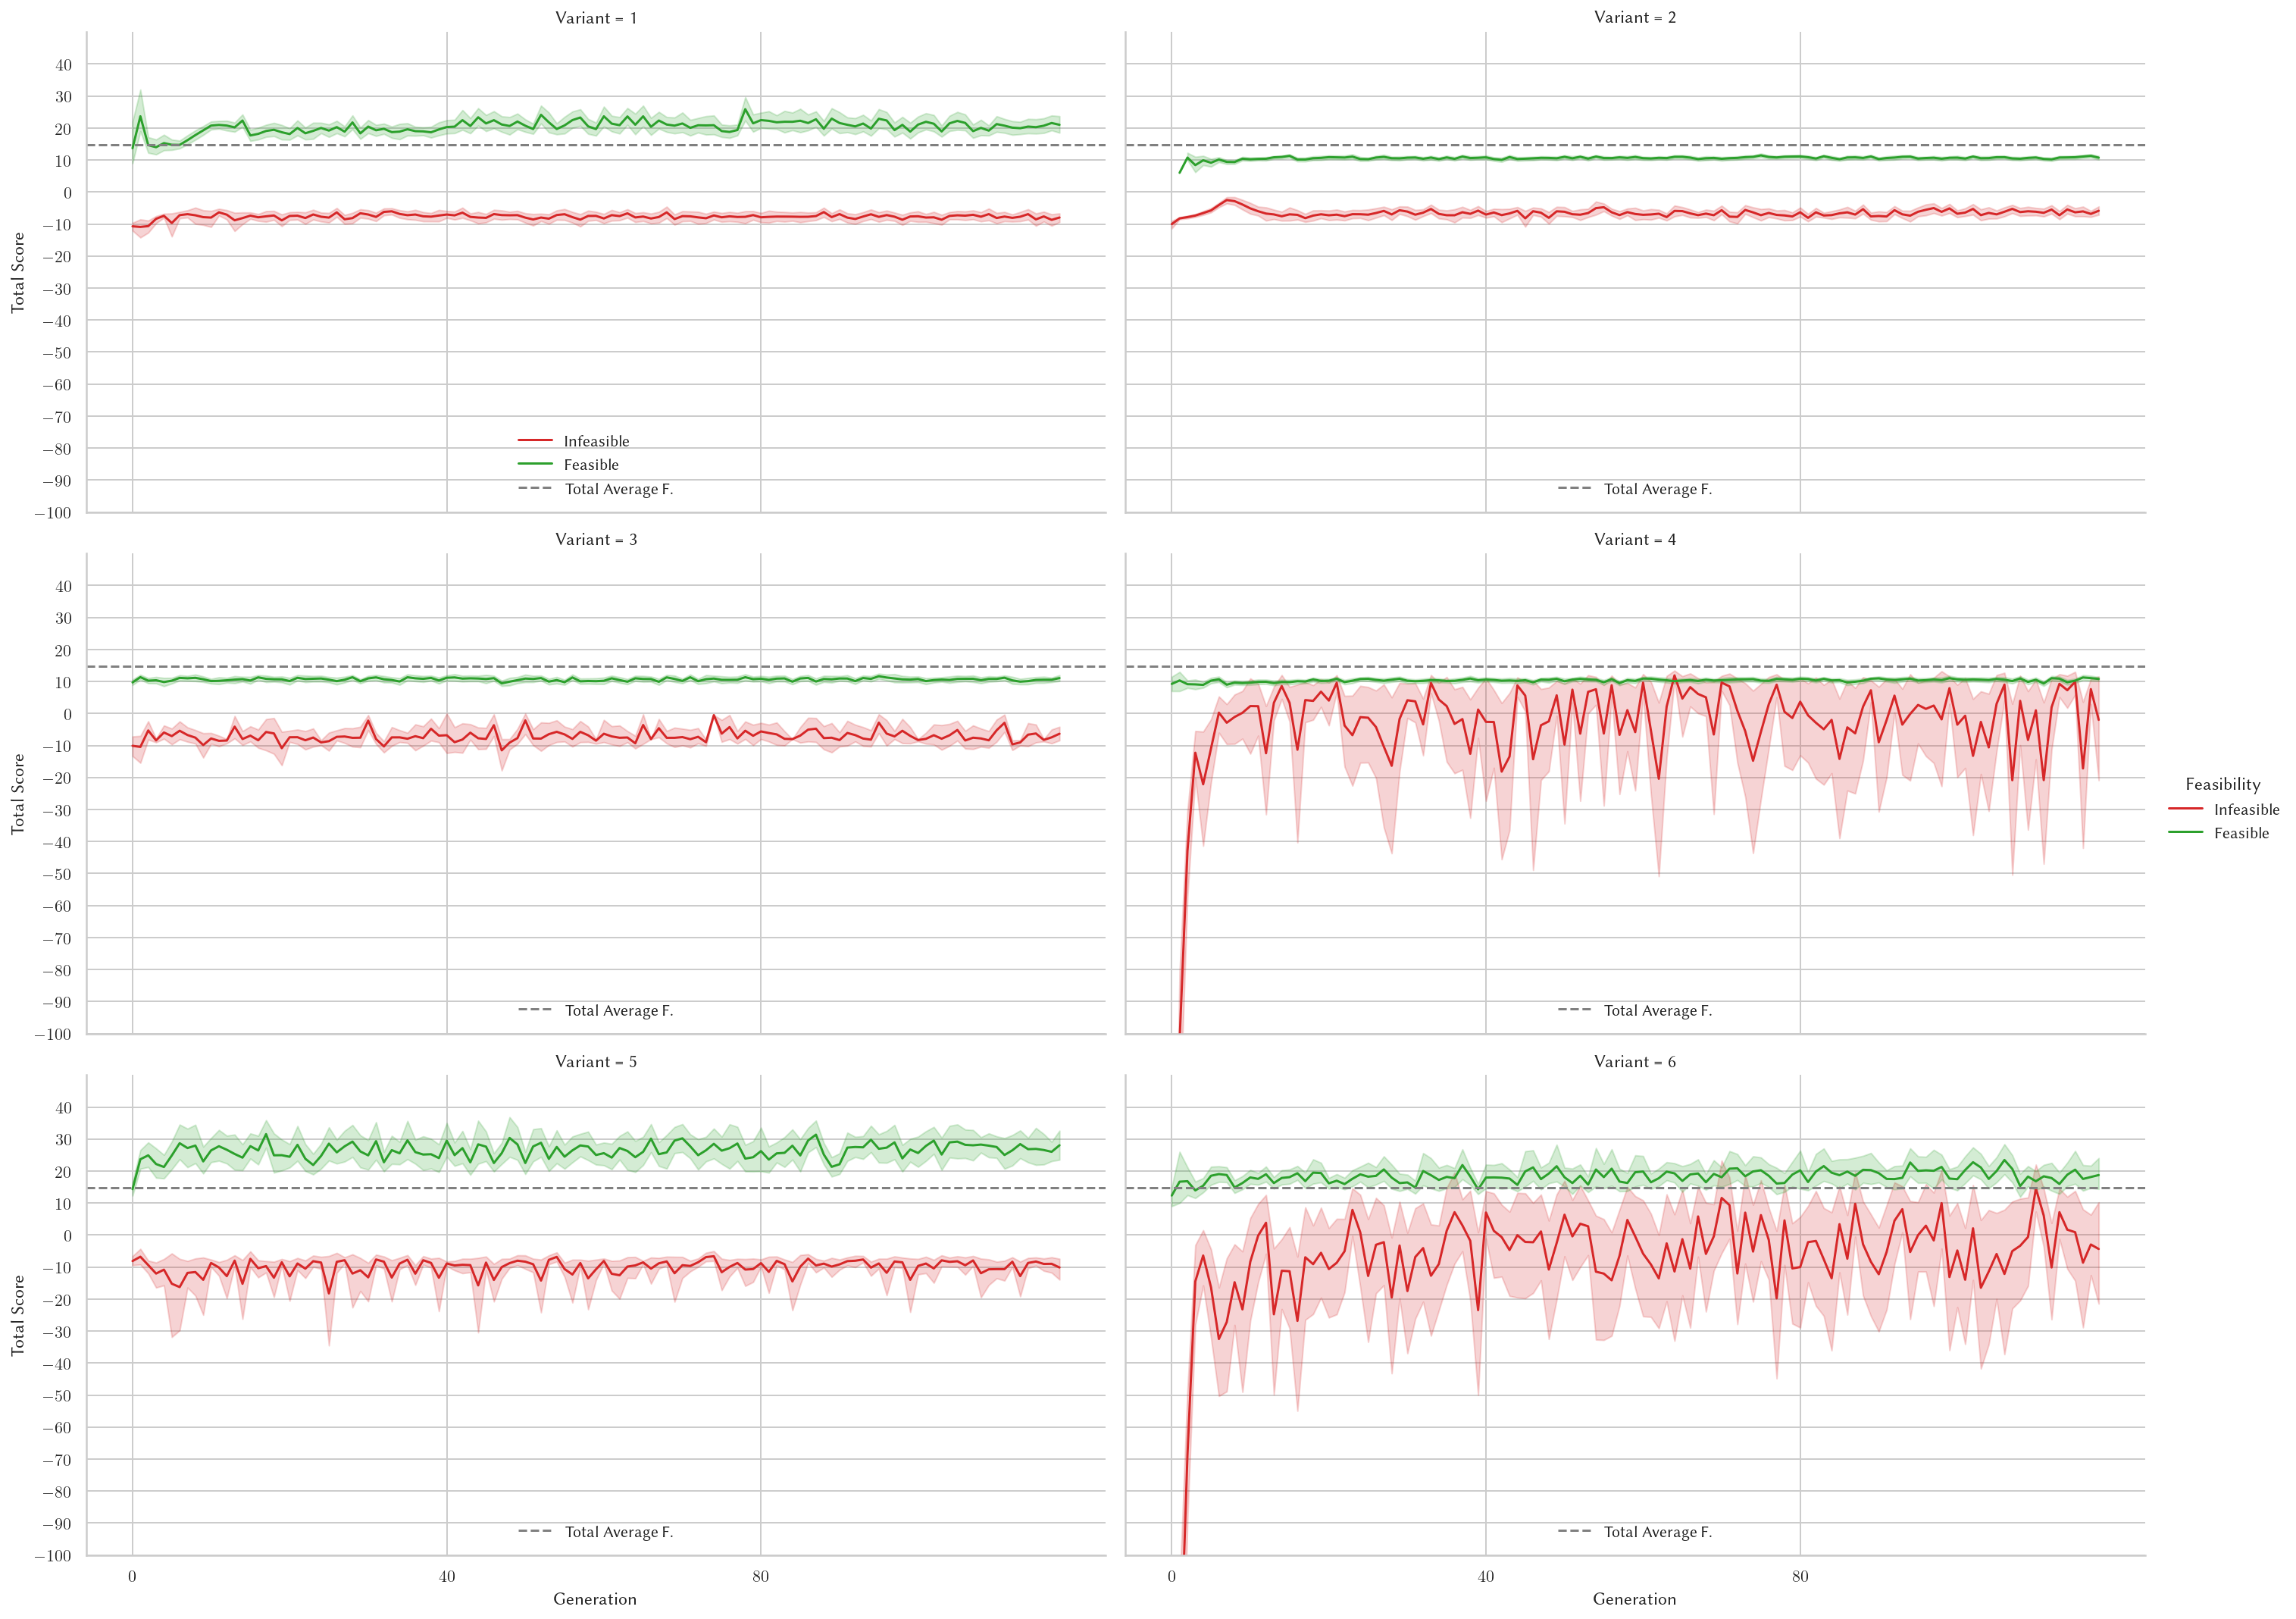

In [342]:
palette = {
    'Feasible': 'tab:green',
    'Infeasible': 'tab:red',
    }
g = sns.relplot(data=result, x='Generation', y='Total Score', hue='Feasibility', legend=True, col='Variant', col_wrap=2, kind="line", palette=palette, aspect=2) 
axes = g.axes
sp = result.loc[result['Feasibility']=='Feasible', 'Total Score'].mean()
delta = 20
for ax in axes:
        ax.axhline(y=sp, color='gray', linestyle='--', label='Total Average F.')
        #ax.axhspan(ymin=sp * (100 - delta) / 100, ymax=sp * (100 + delta) / 100,
        #color='r', alpha=0.15, linestyle='--', label='10%')
        ax.legend(frameon=False, loc="lower center")
sns.despine()

plt.ylim(-100, 50)
plt.yticks(np.arange(-100, 50, step=10)) 
plt.xticks(np.arange(0, 120, step=40)) 
plt.show()

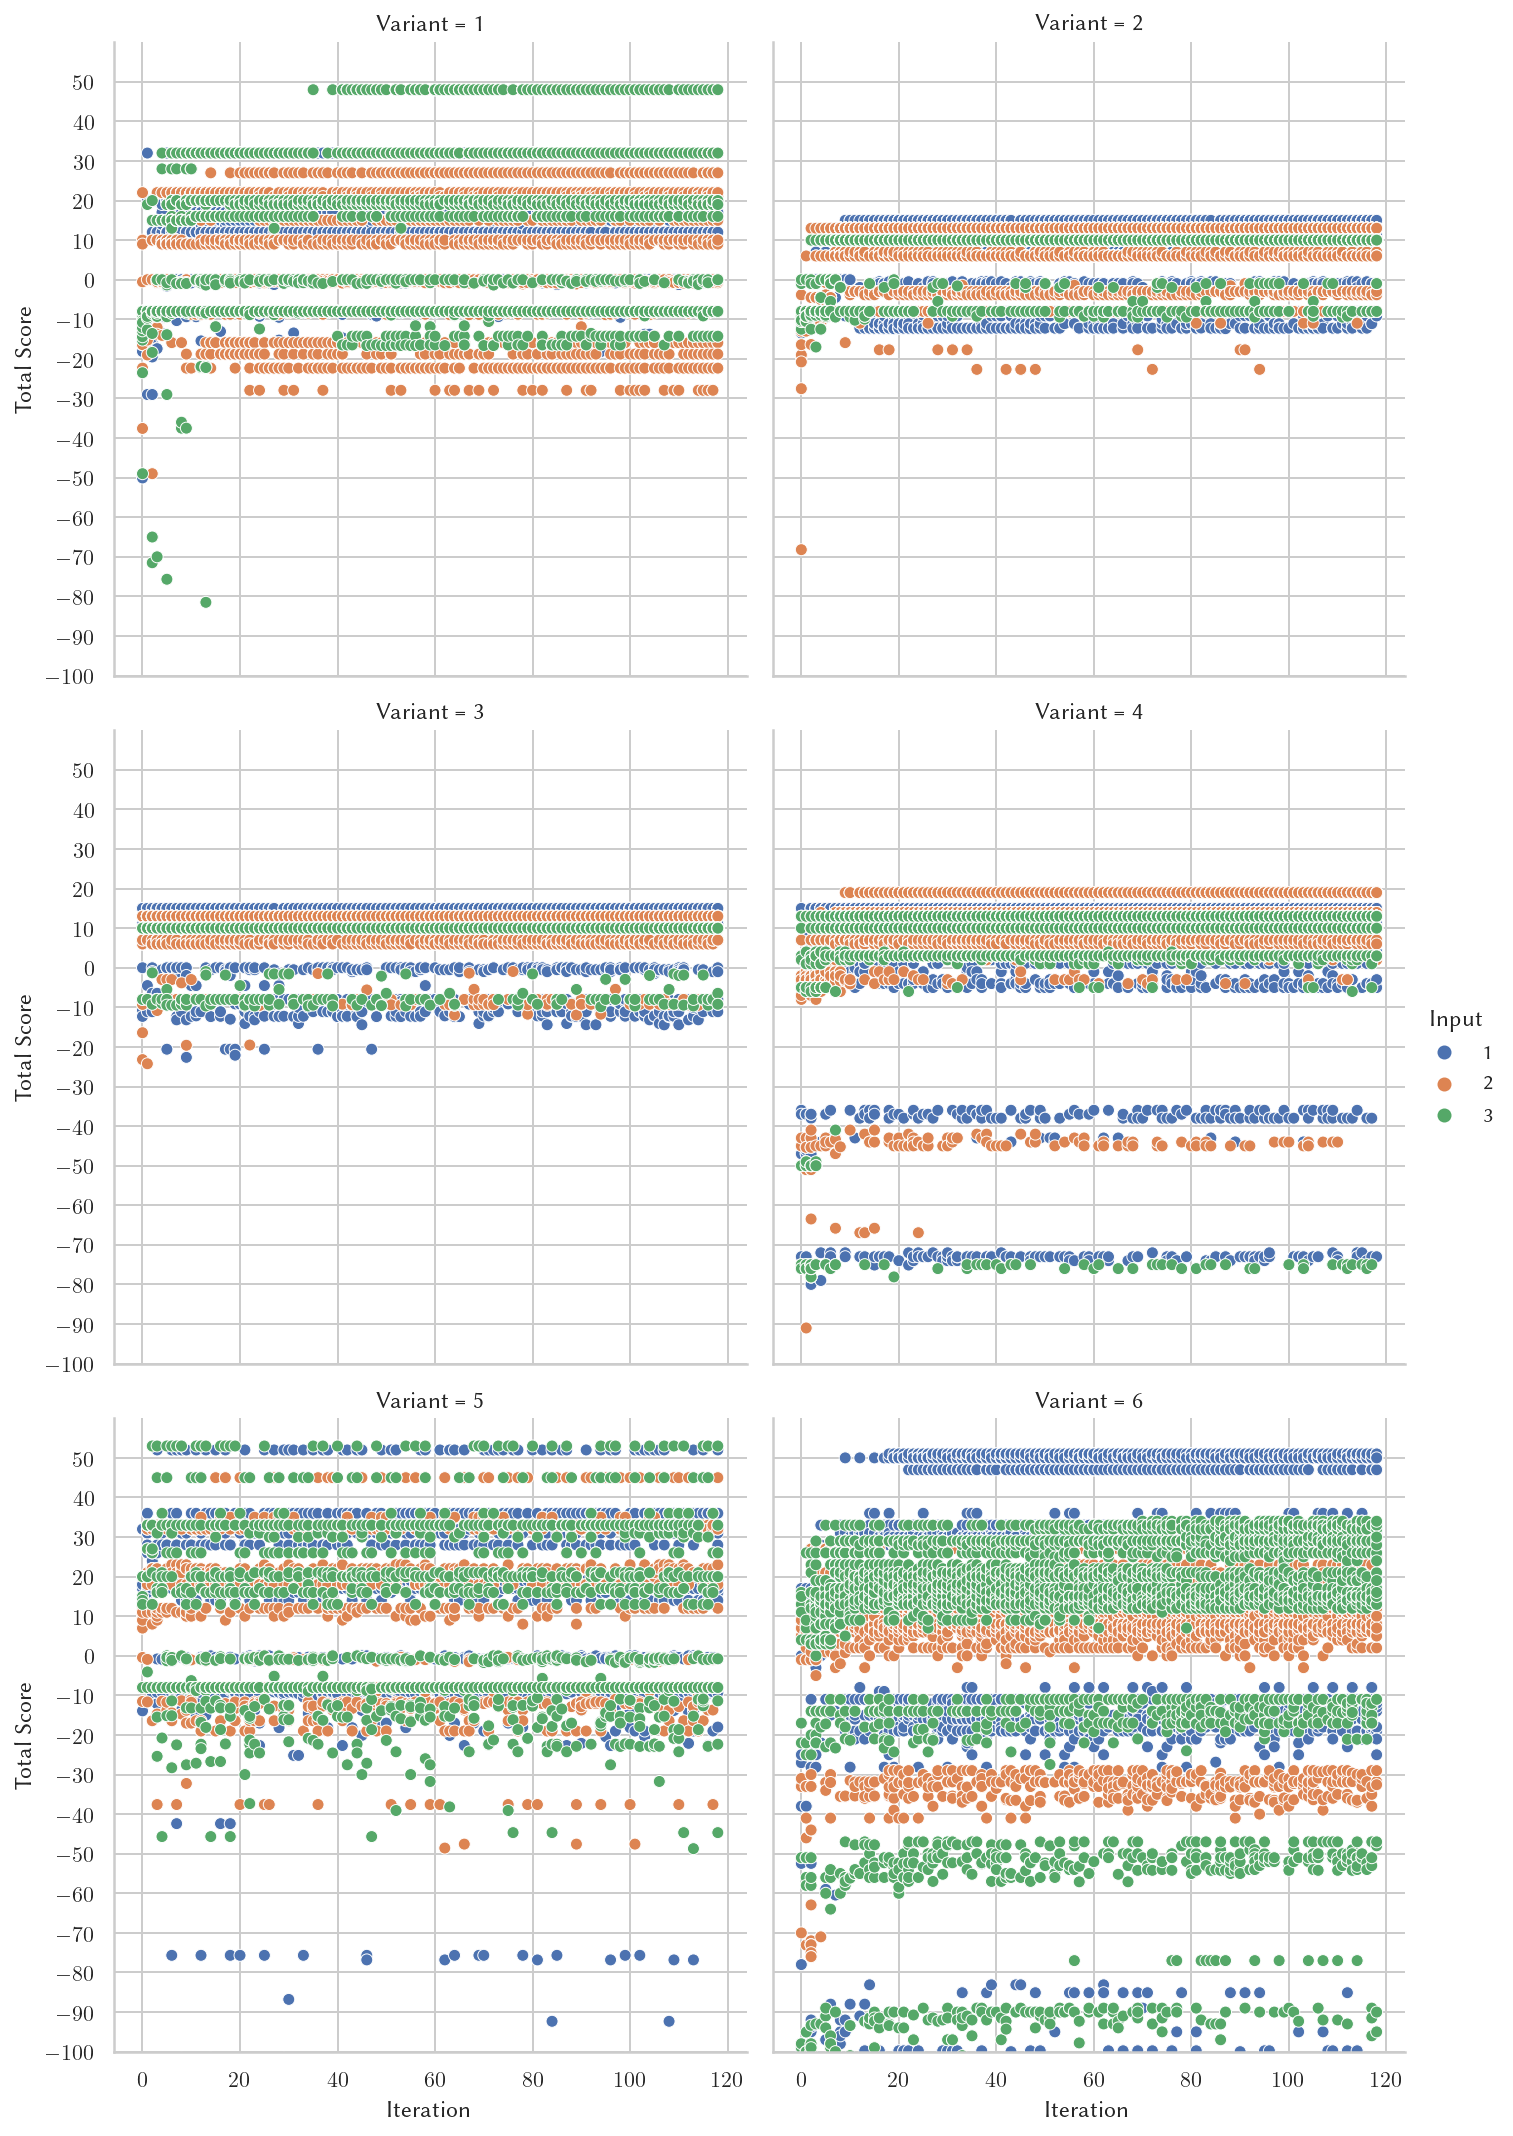

In [23]:

sns.relplot(data=result, hue='Input', x='Iteration', y='Total Score', y_jitter=0.3, legend=True, col='Variant', col_wrap=2, kind="scatter") 
plt.ylim(-100, 60)
plt.yticks(np.arange(-100, 60, step=10)) 
plt.show()